The aim is to generate 256x256 images of the C. elegans embryo using a conditional-GAN, lets explore the dataset first. 

The dataset is scraped from the [EPIC Dataset](https://epic.gs.washington.edu/index.html)

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from albumentations import *
from PIL import Image
import cv2
import numpy as np

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!cp /content/drive/"My Drive"/data/mini_clean_training_data.csv /content/
!cp /content/drive/"My Drive"/frames_raw.zip /content/
!unzip frames_raw.zip

In [4]:
df = pd.read_csv("/content/mini_clean_training_data.csv")
df = df.sample(frac=1)
df.head()

,Unnamed: 0,filenames,A,E,M,P,C,D,Z
501,30159,frames/20090701_tbx-11_RW10249_L1/183.jpg,216,8,40,1,22,8,1
2013,13028,frames/20070801_hnd-1_F396/227.jpg,128,8,21,1,15,4,0
2740,2575,frames/20081014_ref-1_2_L1/126.jpg,64,6,16,0,8,3,2
1095,37678,frames/030906_dyf7red/322.jpg,253,16,42,1,25,8,0
57,25739,frames/20071210_rw10029_norfpxx/58.jpg,4,1,1,0,1,0,0


## What do the columns represent?
1. Column *filenames* contain paths to images.
2. Columns *A, E, M, P, C, D, Z* contain integers representing the number of cells belonging to each cell family for the corresponding image in the same row.

## The Correlation Plot:
The plot below represents how interdependent each column is. Some conclusions that we can derive are:

* The values in columns *A, E, M, P, C, D* are highly interdependent.
* The values in column *Z* are relatively less dependent on the other columns.

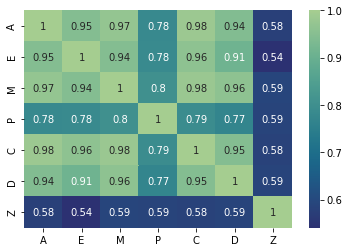

In [5]:
cols=['A', 'E', 'M', 'P', 'C', 'D', 'Z']
sns.heatmap(df[cols].corr(), 
            annot=True, 
            cmap='crest_r')

## Scaling the columns:

* You may have noticed that the values in the columns A,E,M,P,C,D,Z vary wildly, with each column having a different range of values. 
* This need to be fixed, all values that we pass through the neural-net(s) should be scaled between 0 and 1. 
* The cell below creates a copy of the dataframe with scaled values.

In [6]:
def scale_df(df, cols):
  scaler = MinMaxScaler()
  df_scaled=df.copy()
  df_scaled[cols] = scaler.fit_transform(df[cols])
  return(df_scaled)

df_scaled=scale_df(df, cols=['A', 'E', 'M', 'P', 'C', 'D', 'Z'])
df_scaled.to_csv('./preprocessed_df')
df_scaled.head()

,Unnamed: 0,filenames,A,E,M,P,C,D,Z
501,30159,frames/20090701_tbx-11_RW10249_L1/183.jpg,0.808989,0.5000,0.615385,1.0,0.709677,0.5000,0.5
2013,13028,frames/20070801_hnd-1_F396/227.jpg,0.479401,0.5000,0.323077,1.0,0.483871,0.2500,0.0
2740,2575,frames/20081014_ref-1_2_L1/126.jpg,0.239700,0.3750,0.246154,0.0,0.258065,0.1875,1.0
1095,37678,frames/030906_dyf7red/322.jpg,0.947566,1.0000,0.646154,1.0,0.806452,0.5000,0.0
57,25739,frames/20071210_rw10029_norfpxx/58.jpg,0.014981,0.0625,0.015385,0.0,0.032258,0.0000,0.0


## Visualizing the probability densities before and after scaling using seaborn.kdeplot

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

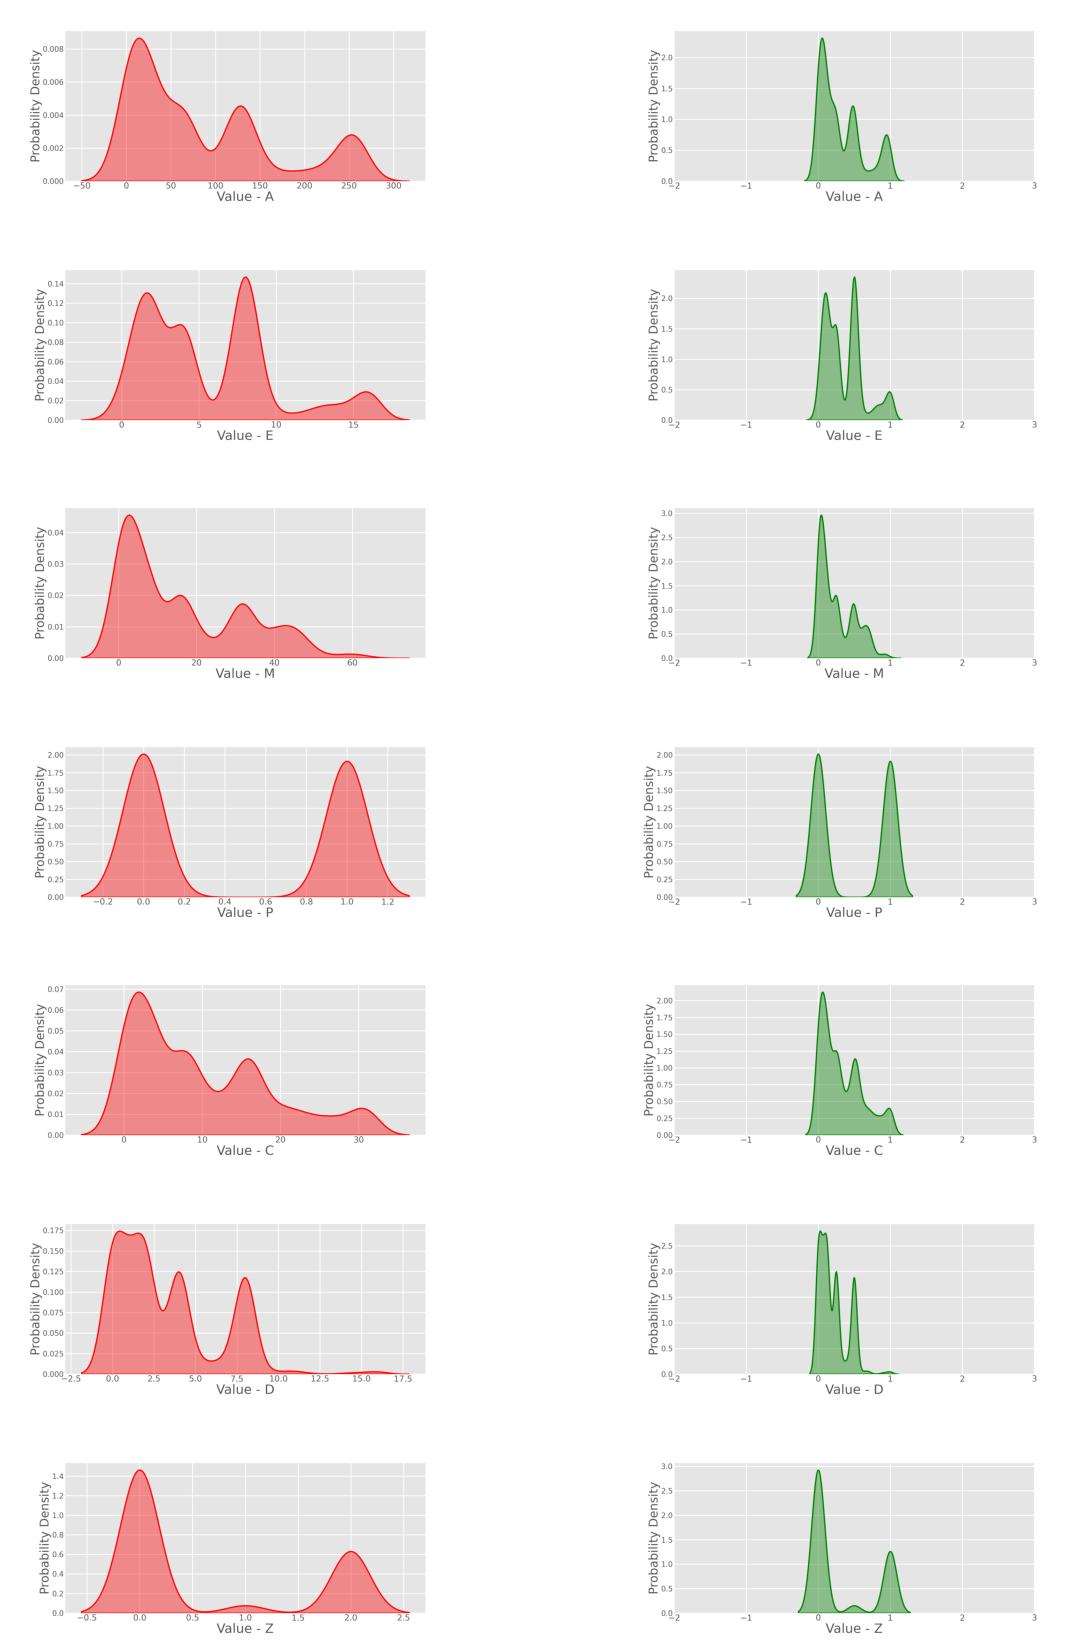

In [7]:
def save_kde_plots(pd_df, cols, color, name, xlims):
    for c in cols:
        plt.style.use('ggplot')
        plt.figure(figsize=(35,15))
        #plt.title('Value - '+c) 
        plt.xlabel('Value - '+c, fontsize=70)
        plt.ylabel('Probability Density', fontsize=65) 
        plt.xticks(fontsize=45, rotation=0)
        plt.yticks(fontsize=40, rotation=0)
        if xlims != None:
          plt.xlim(xlims)


        plt.grid(True, linewidth=5)
        plot=sns.kdeplot(data=pd_df[c],
                         fill=True, 
                         color=color,
                         alpha=.4, 
                         linewidth=7)
        fig_temp=plot.get_figure()
        fig_temp.savefig('./'+name+c+'.png')
        plt.clf()

cols=['A', 'E', 'M', 'P', 'C', 'D', 'Z']
save_kde_plots(df, cols, color='red', name='kde_df', xlims=None)
save_kde_plots(df_scaled, cols, color='green', name='kde_df_scaled', xlims=[-2, 3])

fig, axs = plt.subplots(7,2,figsize=(20,30))  #30 30 is ok
#fig.suptitle('data distribution, before and after scaling')
for i in range(len(cols)):
    axs[i][1].axis('off')
    axs[i][0].axis('off')
    axs[i][1].imshow(plt.imread('./kde_df_scaled'+cols[i]+'.png'))
    axs[i][0].imshow(plt.imread('./kde_df'+cols[i]+'.png'))

## Inference:
Notice that the plots to the left are varying wildly in terms of their x-axis range, while the ones to the right are confined between 0 and 1.
***
## The Dataset class:
Return format: image,label.

Args:
1. csv_path: path to the csv file
2. augmentation: image augmentations using albumentations
3. transform: torch transforms

In [8]:
class ImageDataset(Dataset):   
    def __init__(self, csv_path, augmentation =None, transform = None):
        
        self.df = pd.read_csv(csv_path)
        self.image_paths = self.df.filenames.values
        self.labels = self.df[["A", "E", "M", "P", "C", "D", "Z"]].values
        self.transform = transform
        self.augmentation = augmentation

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = cv2.imread(path)

        if self.augmentation is not None:
            img  = self.augmentation(image = image)
            image = img["image"]
            
        label = torch.Tensor(self.labels[idx]).float()

        return self.transform(image) , label 

    def __len__(self):
        return len(self.image_paths)

In [9]:
full_dataset = ImageDataset(csv_path = './preprocessed_df',
                         augmentation = Compose([ 
                                                VerticalFlip(p=0.5),
                                                HorizontalFlip(p=0.5),
                                            ]),
                        transform = transforms.Compose([    
                                                        transforms.ToPILImage(),
                                                        transforms.Resize((256, 256), interpolation = Image.NEAREST),
                                                        ToTensor(),
                                                        transforms.Normalize(0.5, 0.5, 0.5)
                                                        ]),
                            )

## The DataLoader
This is an iterator using which we can:
1. Batch data
2. Shuffle data
3. Load the data in parallel using multiprocessing workers.

In [10]:
batch_size = 10
vis_dataloader = DataLoader(dataset=full_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=2)
dataloader = DataLoader(dataset=full_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
print(len(dataloader), "batches ")

287 batches 


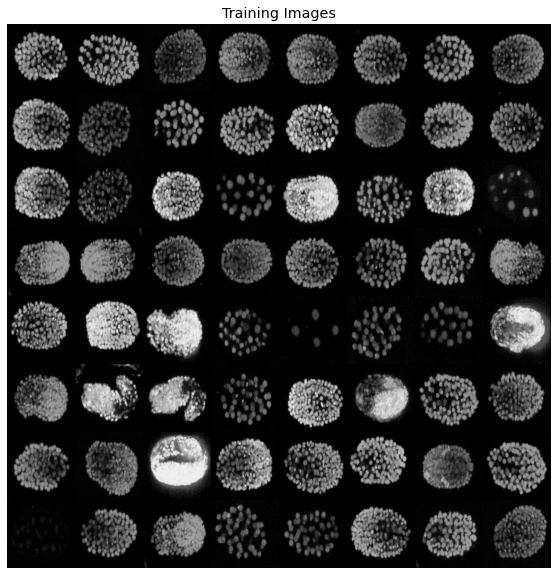

In [11]:
real_batch = next(iter(vis_dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))

## GPU acceleration:
set device as GPU for faster training and inference.

In [12]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


## Define Discriminator net:

In [13]:
#num channels
nc=1
# Size of feature maps in discriminator
ndf = 64

class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)

        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)

        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)

        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)

        self.conv5 = nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 16)

        self.conv6 = nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ndf * 32)

        self.conv7 = nn.Conv2d(ndf * 32, 10, 4, 1, 0, bias=False)

        self.fc1 = nn.Linear(10+7, 15)
        self.fc2 = nn.Linear(15, 1)

    def forward(self, x, labels):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.leaky_relu(self.bn6(self.conv6(x)), 0.2, True)
        x = F.leaky_relu(self.conv7(x))
        x = torch.flatten(x, 1)

        c = labels
        x = torch.cat([x, c], 1)
        x = F.leaky_relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

netD = Discriminator(ngpu).to(device)
print(netD)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn6): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_

## Define Generator net:

In [14]:
#length of latent tensor
nz=100
# Size of feature maps in generator
ngf = 64

class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        # self.label_emb = nn.Embedding(1, 7)

        self.tconv1 = nn.ConvTranspose2d(nz + 7, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 8)

        self.tconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 4)

        self.tconv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 2)

        self.tconv4 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)

        self.tconv5 = nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf)

        self.tconv6 = nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ngf)

        self.tconv7 = nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False)

    def forward(self, x, labels):
        c = labels
        # print("labels init size ", labels.size())
        # print("x size gen ", x.size())
        c = c.unsqueeze(2).unsqueeze(3)
        # print("labels fin size ", c.size())
        # print("emb: ",c.size())
        #print(c)
        # print("emb2: ",c.size())
        # print("x : ",x.size())
        x = torch.cat([x, c], 1)
        #print(x)
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.relu(self.bn5(self.tconv5(x)))
        x = F.relu(self.bn6(self.tconv6(x)))
        x = torch.tanh(self.tconv7(x))
        #print("op ",x.size())

        return x


netG = Generator(ngpu).to(device)
print(netG)

Generator(
  (tconv1): ConvTranspose2d(107, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv6): ConvTranspose2d(64, 64, kernel_size=(4, 4),

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (tconv1): ConvTranspose2d(107, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv6): ConvTranspose2d(64, 64, kernel_size=(4, 4),

## Function to generate fake labels:
* The values of scaled column P are 0 and 1 only.
* The values of scaled column Z are 0, 0.5 and 1 only.
* Rest of the values vary continuously from 0 to 1.

In [16]:
def gen_label_np():
  baseline=np.random.rand(7)
  pain_P = np.random.randint(2)
  possible_values_of_z=np.array([0., 1., 0.5])
  pain_Z = np.random.choice(possible_values_of_z)
  baseline.flat[3] = pain_P
  baseline.flat[-1] = pain_Z
  return(baseline)

def gen_label_batch_torch(batch_size):
  base=np.zeros((batch_size,7))
  for i in range(batch_size): 
    base[i]=gen_label_np()
  return(torch.Tensor(base))

print(gen_label_batch_torch(batch_size=5))

tensor([[0.3236, 0.7805, 0.8314, 0.0000, 0.8523, 0.3521, 1.0000],
        [0.2162, 0.5411, 0.4439, 1.0000, 0.5419, 0.2411, 0.0000],
        [0.5561, 0.3449, 0.6364, 0.0000, 0.9298, 0.2397, 0.0000],
        [0.7164, 0.1967, 0.4210, 1.0000, 0.1971, 0.9435, 0.5000],
        [0.2323, 0.4453, 0.7951, 0.0000, 0.5978, 0.4432, 1.0000]])


## Test Generator:
Lets pass a random generated label and a random latent vector through the generator to make sure the label generator function works. The output should be a 1x256x256 image.

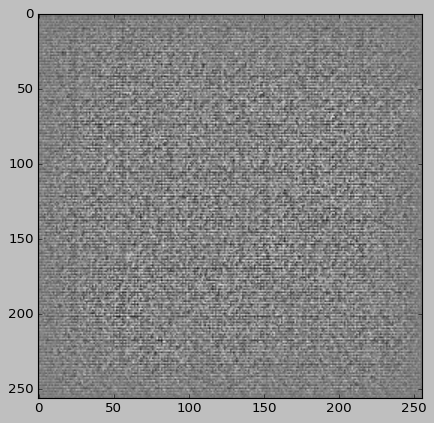

In [19]:
plt.style.use('classic')
single_noise = torch.randn(1, nz, 1, 1, device=device)
with torch.no_grad():
  gen_img = netG(single_noise, gen_label_batch_torch(batch_size=1).to(device)).detach().cpu()
plt.imshow(gen_img.squeeze(), cmap='gray')
plt.show()